### Tumor detector using CNN

Here we will aim to train to identify tumors into three different categories; benign, normal (no tumor) and malignent. 
The dataset is taken from https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset. 

### Loading the datasets

In [2]:
import os
import numpy as np
from PIL import Image
import numpy as np

In [3]:
## Need to filter out mask images, convert to grayscale, resize to 224x224 and then normalize for CNN
def load_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for file in os.listdir(folder):
        if file.endswith('_mask.png'):  
            img = Image.open(os.path.join(folder, file)).convert('L')  
            img = img.resize(target_size)
            img = np.array(img) / 255.0 
            images.append(img)
    return np.array(images)

benign_folder = 'Dataset_BUSI_with_GT/benign'
benign_images = load_images_from_folder(benign_folder)

normal_folder = 'Dataset_BUSI_with_GT/normal'
normal_images = load_images_from_folder(normal_folder)

malignant_folder = 'Dataset_BUSI_with_GT/malignant'
malignant_images = load_images_from_folder(malignant_folder)


print(f"Shape of images: {benign_images.shape}") 
print(f"Shape of images: {normal_images.shape}") 
print(f"Shape of images: {malignant_images.shape}") 

Shape of images: (437, 224, 224)
Shape of images: (133, 224, 224)
Shape of images: (210, 224, 224)


### Dataset Preparation

In [4]:
## Example of what the data looks like. Essentially each element is a 2d array,
## so we have a 3d data structure
benign_images[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Since the datasets have different sizes between benign, normal and malignant, we must first split the data into training, validation and test size.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split each category into train, test, and validation sets
def split_category(images, test_size=0.2, val_size=0.3, random_state=42):
    X_train, X_test = train_test_split(images, test_size=test_size, random_state=random_state)
    X_train, X_val = train_test_split(X_train, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test

# Split each category
benign_train, benign_val, benign_test = split_category(benign_images) 
normal_train, normal_val, normal_test = split_category(normal_images) 
malignant_train, malignant_val, malignant_test = split_category(malignant_images) 


# Concatenate the splits
X_train = np.concatenate([benign_train, normal_train, malignant_train])
X_val = np.concatenate([benign_val, normal_val, malignant_val])
X_test = np.concatenate([benign_test, normal_test, malignant_test])


# We also shape the dataset to have one more dimension for channel, for training CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Create corresponding labels
y_train = np.array([0] * len(benign_train) + [1] * len(normal_train) + [2] * len(malignant_train))
y_val = np.array([0] * len(benign_val) + [1] * len(normal_val) + [2] * len(malignant_val))
y_test = np.array([0] * len(benign_test) + [1] * len(normal_test) + [2] * len(malignant_test))

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (435, 224, 224, 1)
X_val shape: (188, 224, 224, 1)
X_test shape: (157, 224, 224, 1)
y_train shape: (435,)
y_val shape: (188,)
y_test shape: (157,)


### Now coming to the machine learning part

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

In [20]:
model = Sequential([
Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
MaxPooling2D((2, 2)),
Conv2D(64, (3 ,3), activation='relu'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.3),
Dense(3, activation='softmax')
])

## Units are chosen as per common practices, the final layer is softmax because we need 3 way classification
## we will evaluate this on the validation set after training the model 

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,203 (91.20 MB)

 Trainable params: 23,907,203 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Notetoself: Sparse used if output is integer encoded

In [9]:
## Since the model has different number of elements per class, we will add weights so that the 
## smaller class has a greater weight

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight = class_weights)

{0: 0.5942622950819673, 1: 1.9594594594594594, 2: 1.2393162393162394}
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 940ms/step - accuracy: 0.4459 - loss: 1.5145 - val_accuracy: 0.6968 - val_loss: 0.8286
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 839ms/step - accuracy: 0.7075 - loss: 0.7786 - val_accuracy: 0.7660 - val_loss: 0.6235
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 829ms/step - accuracy: 0.8180 - loss: 0.5186 - val_accuracy: 0.7340 - val_loss: 0.6023
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 811ms/step - accuracy: 0.8726 - loss: 0.3338 - val_accuracy: 0.7021 - val_loss: 0.6112
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 771ms/step - accuracy: 0.9307 - loss: 0.1764 - val_accuracy: 0.7660 - val_loss: 0.5904


We already started overfitting since the third epoch, which will be clearer from the graphs below.

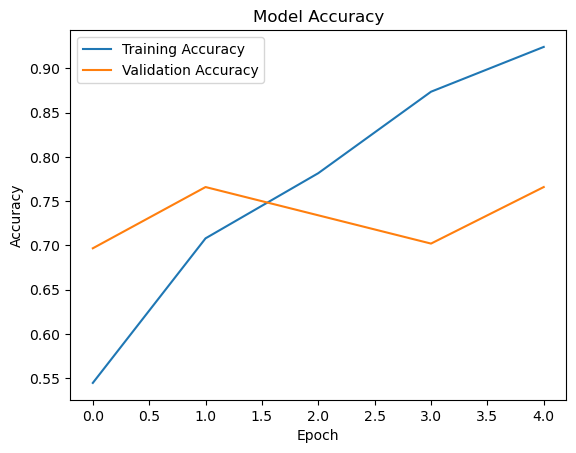

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

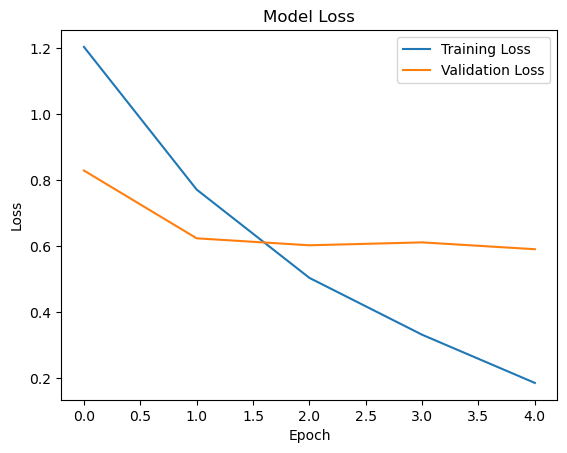

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Since our dataset is fairly small, overfitting isn't a big surprise. 
We can try various approach to avoid overfitting such as adding regularization,
reducing the network size (adding less units), or increasing the dropout rate.
Since, the dropout rate is already 0.3, we can try the other 
two simplest methods first in adding a regularizer and decreasing
the network sizes, or decreasing the learning rate. One problem
that we do notice is that the validation set accurracy is quite high
already on the first trial. This indicates the problem with the fact that our dataset 
is not uniform, we do not have 3 equal number of images in three respective classification.

In [19]:
from tensorflow.keras import regularizers
tf.random.set_seed(42)
np.random.seed(42)

model_revised = Sequential([
Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
MaxPooling2D((2, 2)),
Conv2D(64, (3 ,3), activation='relu'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
Dropout(0.3),
Dense(3, activation='softmax')
])


In [13]:
from tensorflow.keras.optimizers import RMSprop

print("Class weights:", class_weights)
model_revised.compile(optimizer=RMSprop(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history_revised = model_revised.fit(
    X_train, y_train,          
    epochs=5,                
    batch_size=32,            
    validation_data=(X_val, y_val),
    class_weight = class_weights
)

Class weights: {0: 0.5942622950819673, 1: 1.9594594594594594, 2: 1.2393162393162394}
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 804ms/step - accuracy: 0.4686 - loss: 2.0906 - val_accuracy: 0.6809 - val_loss: 1.4651
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 759ms/step - accuracy: 0.6583 - loss: 1.3640 - val_accuracy: 0.7447 - val_loss: 1.0648
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 847ms/step - accuracy: 0.7643 - loss: 0.9888 - val_accuracy: 0.7447 - val_loss: 0.8837
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 925ms/step - accuracy: 0.7920 - loss: 0.7246 - val_accuracy: 0.6862 - val_loss: 0.9129
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 867ms/step - accuracy: 0.8193 - loss: 0.6033 - val_accuracy: 0.6915 - val_loss: 0.8531


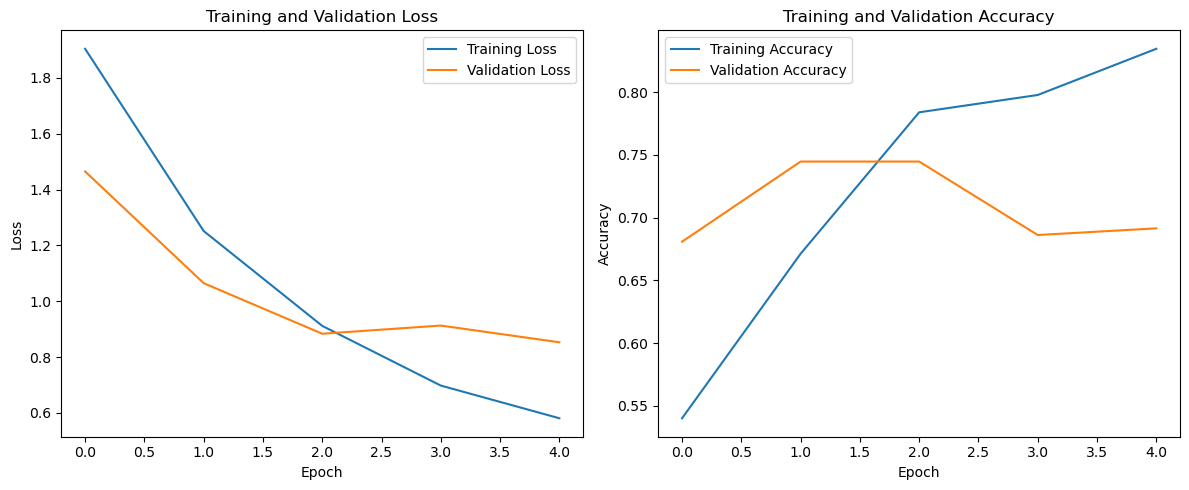

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_revised.history['loss'], label='Training Loss')
plt.plot(history_revised.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_revised.history['accuracy'], label='Training Accuracy')
plt.plot(history_revised.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

final_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])


final_model.compile(optimizer=RMSprop(learning_rate=0.0005),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

class_weights_final = compute_class_weight('balanced', classes=np.unique(y_final_train), y=y_final_train)
class_weights_final = dict(enumerate(class_weights_final))
print("Final class weights:", class_weights_final)

final_history = final_model.fit(
    X_final_train, y_final_train,
    epochs=3,  # We will set the epoch to be 3
    batch_size=32,
    class_weight=class_weights_final
)

Final class weights: {0: 0.5950334288443171, 1: 1.9591194968553458, 2: 1.2361111111111112}
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 747ms/step - accuracy: 0.4340 - loss: 2.0321
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 837ms/step - accuracy: 0.5986 - loss: 1.1139
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 743ms/step - accuracy: 0.7431 - loss: 0.8084


In [17]:
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.2g}")
print(f"Test Accuracy: {test_accuracy:.2g}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7957 - loss: 0.7858
Test Loss: 0.77
Test Accuracy: 0.81
